In [31]:
import math

def newton_isqrt(n):
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x

# now use the parametrized version of the square
def parametrized_objective(a, e, c, scale = True):

    # convert to python ints first, so no overflow with the numpy ints
    a = int(a)
    e = int(e)
    c = int(c)

    a2 = a*a
    e2 = e*e
    c2 = c*c

    # get the "true" values from the squared parameters
    b2 = 3*e2 - a2 - c2
    d2 = e2 - a2 + c2
    f2 = e2 - c2 + a2
    g2 = 2*e2 - c2
    h2 = a2 + c2 - e2
    i2 = 2*e2 - a2

    # take them to the nearest square
    b2 = newton_isqrt(abs(b2))
    b2 *= b2
    d2 = newton_isqrt(abs(d2))
    d2 *= d2
    f2 = newton_isqrt(abs(f2))
    f2 *= f2
    g2 = newton_isqrt(abs(g2))
    g2 *= g2
    h2 = newton_isqrt(abs(h2))
    h2 *= h2
    i2 = newton_isqrt(abs(i2))
    i2 *= i2

    # get all the corresponding sums
    row1 = a2 + b2 + c2
    row2 = d2 + e2 + f2
    row3 = g2 + h2 + i2
    col1 = a2 + d2 + g2
    col2 = b2 + e2 + h2
    col3 = c2 + f2 + i2
    dia1 = a2 + e2 + i2
    dia2 = c2 + e2 + g2

    # find the variance of the sums as the objective
    average = (row1 + row2 + row3 + col1 + col2 + col3 + dia1 + dia2) / 8
    objective = 0
    objective += (row1 - average)*(row1 - average)
    objective += (row2 - average)*(row2 - average)
    objective += (row3 - average)*(row3 - average)
    objective += (col1 - average)*(col1 - average)
    objective += (col2 - average)*(col2 - average)
    objective += (col3 - average)*(col3 - average)
    objective += (dia1 - average)*(dia1 - average)
    objective += (dia2 - average)*(dia2 - average)


    if scale:
        return objective/(2**(max(a2, c2, e2).bit_length()))
    return objective

def parametrized_differential(a, e, c):
    current = parametrized_objective(a, e, c)
    
    da = parametrized_objective(a + 1, e, c) - current
    de = parametrized_objective(a, e + 1, c) - current
    dc = parametrized_objective(a, e, c + 1) - current

    dL = math.sqrt(da*da + de*de + dc*dc)

    return -da/dL, -de/dL, -dc/dL


In [53]:
import math

def parametrized_objective2(a, e, c):
    # convert to python ints first, so no overflow with the numpy ints
    a = int(a)
    e = int(e)
    c = int(c)

    a2 = a*a
    e2 = e*e
    c2 = c*c

    # get the "true" values from the squared parameters, taken to be positive
    b2 = abs(3*e2 - a2 - c2)
    d2 = abs(e2 - a2 + c2)
    f2 = abs(e2 - c2 + a2)
    g2 = abs(2*e2 - c2)
    h2 = abs(a2 + c2 - e2)
    i2 = abs(2*e2 - a2)

    # get how far these values are from the nearest squares, scaled to try and negate the effect of numerical size
    b_err = abs(round(math.sqrt(b2))**2 - b2) / (10**math.floor(math.log10(b2)))
    d_err = abs(round(math.sqrt(d2))**2 - d2) / (10**math.floor(math.log10(d2)))
    f_err = abs(round(math.sqrt(f2))**2 - f2) / (10**math.floor(math.log10(f2)))
    g_err = abs(round(math.sqrt(g2))**2 - g2) / (10**math.floor(math.log10(g2)))
    h_err = abs(round(math.sqrt(h2))**2 - h2) / (10**math.floor(math.log10(h2)))
    i_err = abs(round(math.sqrt(i2))**2 - i2) / (10**math.floor(math.log10(i2)))

    return b_err + d_err + f_err + g_err + h_err + i_err

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class MagicParticle:
    def __init__(self, init_pos):
        self.current_pos = init_pos
        self.current_obj = parametrized_objective2(self.current_pos[0], self.current_pos[1], self.current_pos[2])
        self.best_pos = init_pos
        self.best_obj = self.current_obj
    def update_objective(self):
        self.current_obj = parametrized_objective2(self.current_pos[0], self.current_pos[1], self.current_pos[2])
        if self.current_obj < self.best_obj:
            self.best_obj = self.current_obj
            self.best_pos = self.current_pos
    def descend(self, rate):
        dx, dy, dz = parametrized_differential(self.current_pos[0], self.current_pos[1], self.current_pos[2])
        self.current_pos[0] += dx*rate
        self.current_pos[1] += dy*rate
        self.current_pos[2] += dz*rate
        self.update_objective()
    def update(self, attractor_pos):
        mean = (self.best_pos + attractor_pos) / 2
        stdev = np.linalg.norm(self.best_pos - attractor_pos)
        self.current_pos = np.random.multivariate_normal(mean, np.identity(3) * stdev).astype(int)
        self.update_objective()

def random_particle(x_bound, y_bound, z_bound):
    x = np.random.randint(1, x_bound)
    y = np.random.randint(1, y_bound)
    z = np.random.randint(1, z_bound)
    return MagicParticle(np.array([x, y, z]))

class MagicSwarm:
    def __init__(self, num_particles, x_bound, y_bound, z_bound):
        self.particles = [random_particle(x_bound, y_bound, z_bound) for _ in range(num_particles)]
    
        self.global_best_pos = self.particles[0].current_pos
        self.global_best_obj = self.particles[0].current_obj

        # set the initial global best from the known starting positions
        for particle in self.particles:
            if particle.current_obj < self.global_best_obj:
                self.global_best_obj = particle.current_obj
                self.global_best_pos = particle.current_pos

    def descent_step(self, descent_rate):
        for particle in self.particles:
            particle.descend(descent_rate)
            if particle.current_obj < self.global_best_obj:
                self.global_best_obj = particle.current_obj
                self.global_best_pos = particle.current_pos

    def update_step(self):
        for particle in self.particles:
            particle.update(self.global_best_pos)
            if particle.current_obj < self.global_best_obj:
                self.global_best_obj = particle.current_obj
                self.global_best_pos = particle.current_pos

    def update_loop(self, n_iter):
        for i in range(n_iter):
            self.update_step()

    def descent_loop(self, n_iter, descent_rate, descent_decay):
        for i in range(n_iter):
            self.descent_step(descent_rate)
            descent_rate *= descent_decay
            descent_rate = max(1, descent_rate)

    def plot_swarm(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        x_data = []
        y_data = []
        z_data = []
        color_data = []
        for particle in self.particles:
            x_data.append(particle.current_pos[0])
            y_data.append(particle.current_pos[1])
            z_data.append(particle.current_pos[2])
            color_data.append(particle.current_obj)

        ax.scatter3D(x_data, y_data, z_data, c=color_data, cmap='hot');


In [51]:
import statistics

class MultiSwarm:
    def __init__(self, num_swarms, num_particles_per_swarm, x_bound, y_bound, z_bound):
        self.xb = x_bound
        self.yb = y_bound
        self.zb = z_bound
        self.swarms = [MagicSwarm(num_particles_per_swarm, x_bound, y_bound, z_bound) for _ in range(num_swarms)]
    def update_step(self):
        for swarm in self.swarms:
            swarm.update_step()
    def descent_step(self, descent_rate):
        for swarm in self.swarms:
            swarm.descent_step(descent_rate)
    def plot_all_swarms(self, clamp_color):
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        ax.set_xlim(self.xb)
        ax.set_ylim(self.yb)
        ax.set_zlim(self.zb)

        # ax.xaxis.set_ticks_position('upper')
        # ax.yaxis.set_ticks_position('lower')
        # ax.zaxis.set_ticks_position('upper')

        x_data = []
        y_data = []
        z_data = []
        color_data = []
        for swarm in self.swarms:
            for particle in swarm.particles:
                x_data.append(particle.current_pos[0])
                y_data.append(particle.current_pos[1])
                z_data.append(particle.current_pos[2])
                color_data.append(particle.current_obj)

        if clamp_color:
            median_color = statistics.median(color_data)
            clamped_color = [min(median_color, x) for x in color_data]
            color_data = clamped_color

        ax.scatter3D(x_data, y_data, z_data, c=color_data, cmap='hot');
    def best_so_far(self):
        best_obj = None
        best_pos = None
        for swarm in self.swarms:
            if not best_obj or swarm.global_best_obj < best_obj:
                best_obj = swarm.global_best_obj
                best_pos = swarm.global_best_pos
        return best_pos, best_obj

In [54]:
mswarm = MultiSwarm(1000, 100, 1_000_000_000, 1_000_000_000, 1_000_000_000)


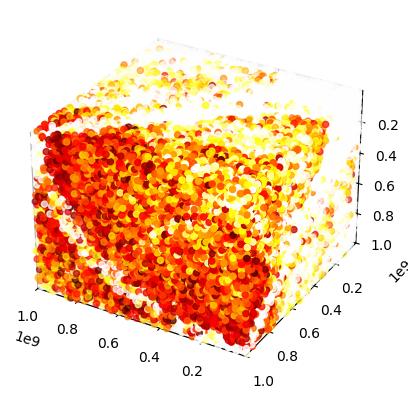

In [55]:
mswarm.plot_all_swarms(clamp_color=True)

In [40]:
descent_rate = 10_000
descent_decay = 0.9999

0 (array([767306718, 113216891, 861234502]), 9.49998154e-10)
1 (array([767306718, 113216891, 861234502]), 9.49998154e-10)
2 (array([767306718, 113216891, 861234502]), 9.49998154e-10)
3 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
4 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
5 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
6 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
7 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
8 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
9 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
10 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
11 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
12 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
13 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
14 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
15 (array([783949056, 905566342, 147166667]), 4.81170208e-10)
16 (array([7839490

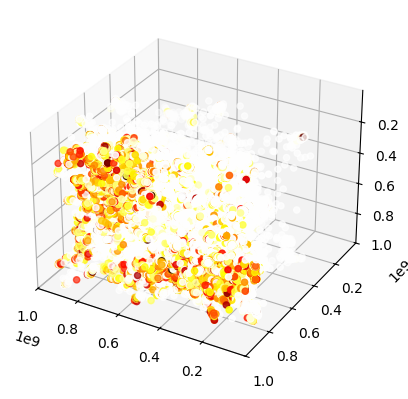

In [56]:
for i in range(500):
    #mswarm.descent_step(descent_rate)
    mswarm.update_step()
    #descent_rate *= descent_decay
    print(i, mswarm.best_so_far())
mswarm.plot_all_swarms(clamp_color=True)

In [ ]:
# some tweaks to make:
# - currently there is a bias toward smaller values, because they naturally generate smaller objective values. Scale the objective by the size of the input
# - currently there is no bounds checking for values < 0 or values which cause entries to be the same. Gotta do that, at least the first part

In [ ]:
swarm.global_best_pos

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');